In [1]:
LENGTHS = 'stability.pkl.bz2'
TRANSMISSIBILITY = 'transmissibility.pkl.bz2'
VARIABILITY = 'variability.pkl.bz2'
EXP_DEPTHS = {1: 8, 2: 7, 3: 10}
SAVE_FIG = True

In [2]:
%matplotlib inline
import pandas as pd
import seaborn as sb
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid.inset_locator import inset_axes, zoomed_inset_axes

sb.set()

# 1 Drastic reduction in content length

In [3]:
exp1 = pd.read_pickle('exp_1/' + LENGTHS)
exp2 = pd.read_pickle('exp_2/' + LENGTHS)
exp3 = pd.read_pickle('exp_3/' + LENGTHS)

# sentence id here is the id of the child
exp1 = exp1[['depth',
             'rate',
             'root length', 'length',
             'tree id', 'sentence id']]\
    .rename(columns={'rate': 'oc rate',
                     'length': 'content length',
                     'root length': 'root content length',
                     'sentence id': 'child id'})
exp2 = exp2[['depth',
             'ordered content rate',
             'root length', 'length',
             'tree id', 'sentence id']]\
    .rename(columns={'ordered content rate': 'oc rate',
                     'length': 'content length',
                     'root length': 'root content length',
                     'sentence id': 'child id'})
exp3 = exp3[['depth',
             'oc rate',
             'root length', 'length',
             'tree id', 'sentence id']]\
    .rename(columns={'length': 'content length',
                     'root length': 'root content length',
                     'sentence id': 'child id'})

exp1['experiment id'] = 1
exp2['experiment id'] = 2
exp3['experiment id'] = 3

lengths = pd.concat([exp1, exp2, exp3], ignore_index=True)
del exp1, exp2, exp3
# Remove sentences too deep for each experiment
lengths = lengths[((lengths['experiment id'] == 1) & (lengths.depth <= EXP_DEPTHS[1])
                   | (lengths['experiment id'] == 2) & (lengths.depth <= EXP_DEPTHS[2])
                   | (lengths['experiment id'] == 3) & (lengths.depth <= EXP_DEPTHS[3]))]

Exp 1: r = -0.29 ; p = 1.2e-32
Exp 2: r = -0.07 ; p = 0.00039
Exp 3: r = -0.46 ; p = 7.4e-156


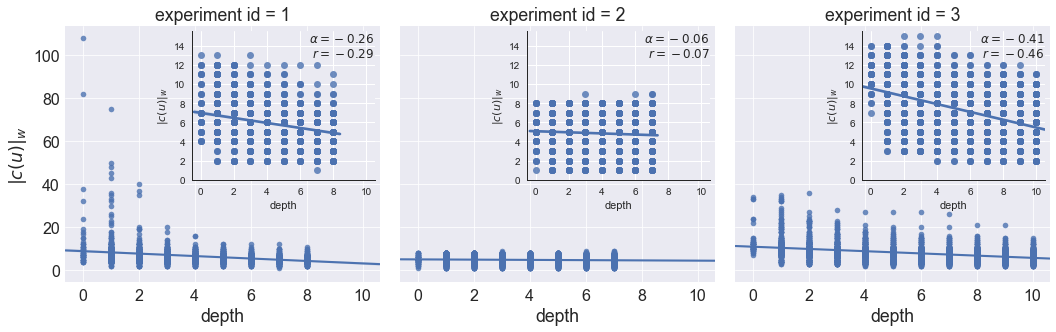

In [4]:
with sb.plotting_context('paper', font_scale=2):
    g = sb.lmplot('depth', 'content length', lengths, col='experiment id')
    g.set_ylabels('$|c(u)|_w$')

# Plot insets
large_content = 15
inxlim = (-.5, lengths[lengths['root content length'] < large_content].depth.max()+.5)
inylim = (0, lengths[lengths['root content length'] < large_content]['content length'].max()+.5)
for i, ax in enumerate(g.axes.ravel()):
    # plot inset
    with sb.axes_style(rc={'axes.edgecolor': '.15', 'axes.linewidth': 1}):
        inax = inset_axes(ax, width='58%', height='58%', loc=1)
    indata = lengths[(lengths['experiment id'] == i+1)
                     & (lengths['root content length'] < large_content)]
    sb.regplot('depth', 'content length', indata, ax=inax)
    inax.set_ylabel('$|c(u)|_w$')
    sb.despine()
    inax.set_xlim(inxlim)
    inax.set_ylim(inylim)
    # compute slope
    α, _, r, p, e = stats.linregress(indata.depth, indata['content length'])
    print('Exp {exp}: r = {r:.2f} ; p = {p:.2g}'.format(exp=i + 1, r=r, p=p))
    inax.text(inxlim[1], inylim[1],
              '$\\alpha = {α:.2f}$\n$r = {r:.2f}$'.format(α=α, r=r),
              ha='right', va='top')
    # format ticks
    ax.locator_params(integer=True)
    inax.locator_params(integer=True, min_n_ticks=5)

if SAVE_FIG:
    g.fig.savefig('lengths.png', dpi=300)

# 2 Transmissibilities vary with experiment

In [5]:
exp1 = pd.read_pickle('exp_1/' + TRANSMISSIBILITY)
exp2 = pd.read_pickle('exp_2/' + TRANSMISSIBILITY)
exp3 = pd.read_pickle('exp_3/' + TRANSMISSIBILITY)

# sentence id here is the id of the parent
exp1 = exp1.rename(columns={'transmit success': 'content transmitted',
                            'length': 'content length',
                            'root length': 'root content length',
                            'sentence id': 'parent id'})
exp2 = exp2.rename(columns={'transmit success': 'content transmitted',
                            'length': 'content length',
                            'root length': 'root content length',
                            'sentence id': 'parent id'})
exp3 = exp3[['depth',
             'transmit success',
             'root length', 'length',
             'tree id', 'branch id', 'sentence id']]\
    .rename(columns={'transmit success': 'content transmitted',
                     'length': 'content length',
                     'root length': 'root content length',
                     'sentence id': 'parent id'})

exp1['experiment id'] = 1
exp2['experiment id'] = 2
exp3['experiment id'] = 3

t14y = pd.concat([exp1, exp2, exp3], ignore_index=True)
del exp1, exp2, exp3
# Remove sentences too deep for each experiment
t14y = t14y[((t14y['experiment id'] == 1) & (t14y.depth <= EXP_DEPTHS[1] - 1)
             | (t14y['experiment id'] == 2) & (t14y.depth <= EXP_DEPTHS[2] - 1)
             | (t14y['experiment id'] == 3) & (t14y.depth <= EXP_DEPTHS[3] - 1))]

In [6]:
def plot_transmissibility(data, **kwargs):
    color = kwargs.get('color', sb.color_palette()[0])
    transmit = kwargs.get('transmit', 'transmit success')
    stop = kwargs.get('stop', True)
    line_kws = kwargs.get('line_kws', {})
    depth_success = data.groupby('depth')[transmit]
    exp_id = data['experiment id'].iloc[0]

    # Compute transmissibilities per depth
    heights = depth_success.mean()
    cis = (stats.t.ppf(1 - .5/2, depth_success.size() - 1)
           * depth_success.std(ddof=1)
           / np.sqrt(depth_success.size()))
    heights[np.isnan(cis)] = np.nan
    #if np.isnan(heights).all():
    #    return

    # Plot
    ax = plt.gca()
    ax.plot(heights.index, heights, color=color, **line_kws)
    ax.fill_between(heights.index, heights - cis, heights + cis,
                    color=sb.desaturate(color, 0.2), alpha=0.2)
    if stop:
        ax.vlines(EXP_DEPTHS[exp_id] - 1, 0, 1, color='orange',
                  lw=1, linestyles='dashed', label='max depth')
    ax.set_ylim(0, 1)
    ax.set_xlabel('depth')
    ax.set_ylabel(transmit)

In [7]:
def scale(bbox, add_width=.2):
    bbox = np.array(bbox)
    rest = 1 - add_width
    bbox[:,0] = 1 - (1 - bbox[:,0]) * rest
    return bbox

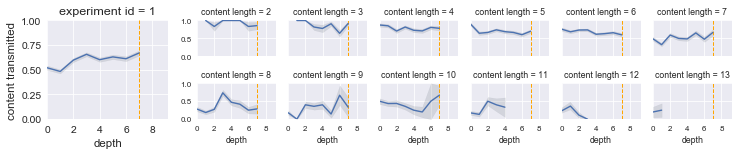

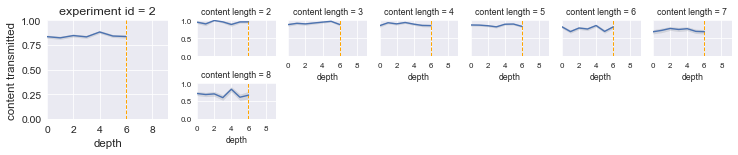

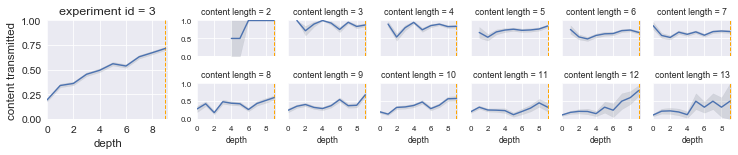

In [8]:
exp_col_orders = {
    1: range(2, 14),
    2: range(2, 9),
    3: range(2, 14)
}
col_wrap = 6
rows = np.max([int(np.ceil(len(col_order) / col_wrap))
               for col_order in exp_col_orders.values()])
main_width = 1 / 5
main_margin = 1 / (10 * col_wrap)
xlim = (0, np.array(list(EXP_DEPTHS.values())).max() - .8)

for eid in range(1, 4):
    with sb.plotting_context('paper', font_scale=1):
        exp_t14y = t14y[(t14y['content length'] < large_content)
                        & (t14y['experiment id'] == eid)]
        g = sb.FacetGrid(exp_t14y,
                         col='content length', col_order=exp_col_orders[eid],
                         col_wrap=col_wrap,
                         size=1, margin_titles=True, xlim=xlim,
                         aspect=rows / (col_wrap * main_width))
        g.map_dataframe(plot_transmissibility, transmit='content transmitted')
        g.set_xlabels('depth')

    for (i,j,k), data in g.facet_data():
        ax = g.facet_axis(i, j)
        bbox = scale(ax.get_position(), add_width=main_width + main_margin)
        ax.set_position([bbox[0,0], bbox[0,1], bbox[1,0]-bbox[0,0], bbox[1,1]-bbox[0,1]])
        ax.locator_params(integer=True, min_n_ticks=3)
    
    with sb.plotting_context('paper', font_scale=1.3):# / (3 * main_width)):
        ax = plt.subplot2grid((1, int(1 / main_width)), (0, 0))#, rowspan=2)
        ax.set_title('experiment id = {}'.format(eid))
        plot_transmissibility(exp_t14y, transmit='content transmitted', ax=ax)
        ax.set_xlim(xlim)
        ax.locator_params(integer=True, min_n_ticks=5)
        sb.despine()

    if SAVE_FIG:
        g.fig.savefig('transmissibilities-exp-{}.png'.format(eid),
                      dpi=300, bbox_inches='tight')

# 3 Transformation rates

In [9]:
rates = lengths[lengths.depth > 0].copy()  # Remove the roots
rates.depth = rates.depth - 1  # And shift depths to have the depth of the parent of 'child id'
rates['content transmitted'] = rates['oc rate'] == 0
rates['1 - oc rate'] = 1 - rates['oc rate']

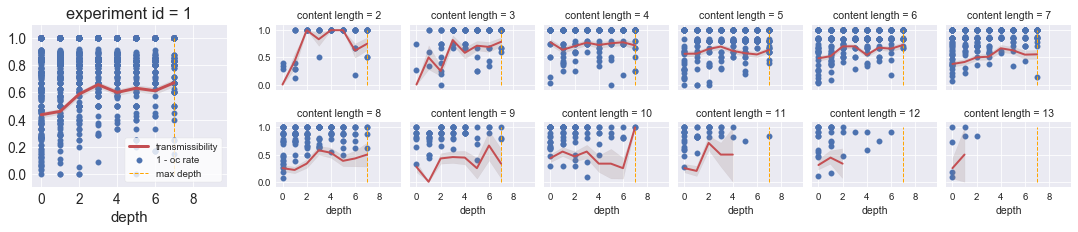

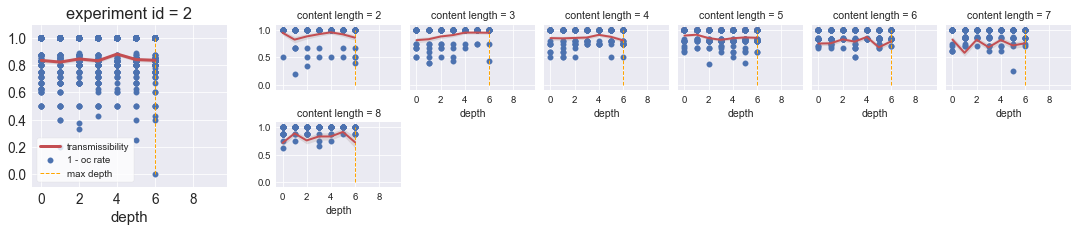

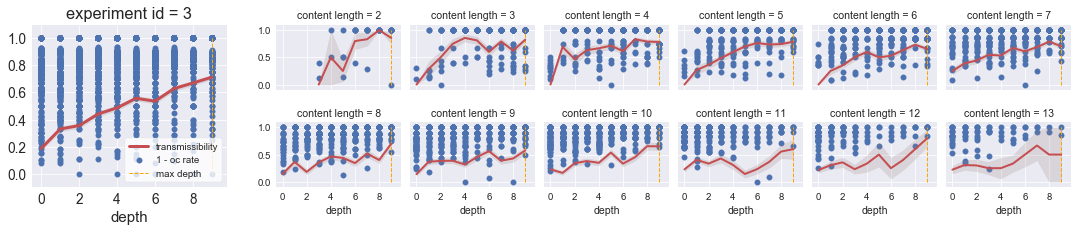

In [10]:
exp_col_orders = {
    1: range(2, 14),
    2: range(2, 9),
    3: range(2, 14)
}
col_wrap = 6
rows = np.max([int(np.ceil(len(col_order) / col_wrap))
               for col_order in exp_col_orders.values()])
main_width = 1 / 5
main_margin = 1 / (5 * col_wrap)
xlim = (-.5, np.array(list(EXP_DEPTHS.values())).max() - .2)
ylim = (-.1, 1.1)

for eid in range(1, 4):
    with sb.plotting_context('paper', font_scale=1.2):
        exp_rates = rates[(rates['content length'] < large_content)
                        & (rates['experiment id'] == eid)]
        g = sb.FacetGrid(exp_rates,
                         col='content length', col_order=exp_col_orders[eid],
                         col_wrap=col_wrap,
                         size=1.5, margin_titles=True, xlim=xlim,
                         aspect=rows / (col_wrap * main_width))
        g.map(plt.scatter, 'depth', '1 - oc rate')
        g.map_dataframe(plot_transmissibility, transmit='content transmitted',
                        line_kws={'lw': 2},
                        color=sb.color_palette()[2])
        g.set(ylim=ylim)
        g.set_xlabels('depth')

    for (i,j,k), data in g.facet_data():
        ax = g.facet_axis(i, j)
        bbox = scale(ax.get_position(), add_width=main_width + main_margin)
        ax.set_position([bbox[0,0], bbox[0,1], bbox[1,0]-bbox[0,0], bbox[1,1]-bbox[0,1]])
        ax.locator_params(integer=True, min_n_ticks=3)
    
    with sb.plotting_context('paper', font_scale=1.7):# / (3 * main_width)):
        ax = plt.subplot2grid((1, int(1 / main_width)), (0, 0))#, rowspan=2)
        ax.set_title('experiment id = {}'.format(eid))
        plt.scatter(exp_rates['depth'], exp_rates['1 - oc rate'])
        plot_transmissibility(exp_rates, transmit='content transmitted',
                              ax=ax, color=sb.color_palette()[2],
                              line_kws={'lw': 3, 'label': 'transmissibility'})
        ax.set_ylabel('')
        ax.set_xlabel('depth')
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        with sb.plotting_context('paper', font_scale=1.2):
            legend = ax.legend(loc='best', frameon=True)
            frame = legend.get_frame()
            frame.set_facecolor('white')
        ax.locator_params(integer=True, min_n_ticks=5)
        sb.despine()

    if SAVE_FIG:
        g.fig.savefig('oc-rates-trans-exp-{}.png'.format(eid),
                      dpi=300, bbox_inches='tight')

# 4 Variability

In [11]:
exp1 = pd.read_pickle('exp_1/' + VARIABILITY)
exp2 = pd.read_pickle('exp_2/' + VARIABILITY)
exp3 = pd.read_pickle('exp_3/' + VARIABILITY)

exp1 = exp1.rename(columns={'slice variabilities': 'slice variability',
                            'root length': 'root content length'})
exp2 = exp2.rename(columns={'slice variabilities': 'slice variability',
                            'root length': 'root content length'})
exp3 = exp3.rename(columns={'slice variabilities': 'slice variability',
                            'root length': 'root content length'})

exp1['experiment id'] = 1
exp2['experiment id'] = 2
exp3['experiment id'] = 3

v11s = pd.concat([exp1, exp2, exp3], ignore_index=True)
del exp1, exp2, exp3
# Remove sentences too deep for each experiment
v11s = v11s[((v11s['experiment id'] == 1) & (v11s.depth <= EXP_DEPTHS[1])
             | (v11s['experiment id'] == 2) & (v11s.depth <= EXP_DEPTHS[2])
             | (v11s['experiment id'] == 3) & (v11s.depth <= EXP_DEPTHS[3]))]
v11s = v11s.groupby(['experiment id', 'tree id', 'depth'], as_index=False).mean()

In [12]:
def plot_slice_variability(**kwargs):
    data = kwargs['data']
    gdata = data.groupby('depth', as_index=False)
    color = kwargs.get('color', sb.color_palette()[0])
    
    x = gdata.first()['depth']
    y = gdata.mean()['slice variability']
    ci = gdata['slice variability'].aggregate({
            'ci': lambda v: (stats.t.ppf(1 - .5/2, len(v) - 1)
                             * v.std(ddof=1)
                             / np.sqrt(len(v)))
    })['ci']
    
    plt.plot(x, y, color=color, label='mean variability')
    plt.fill_between(x, y - ci, y + ci, color=sb.desaturate(color, 0.2), alpha=0.2)

    return plt.gca()

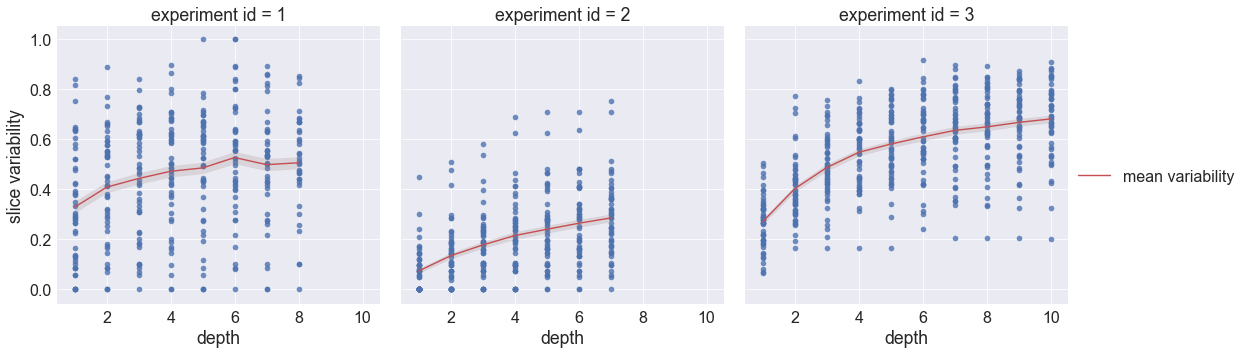

In [13]:
sb.set()
with sb.plotting_context('paper', font_scale=2):
    g = sb.lmplot('depth', 'slice variability', v11s, col='experiment id', fit_reg=False)
    g.map_dataframe(plot_slice_variability, color=sb.color_palette()[2])
    g.set_xlabels('depth')
    g.set_ylabels('slice variability')
    g.add_legend()

if SAVE_FIG:
    g.fig.savefig('variabilities.png', dpi=300)